In [1]:
!pip install tensorflow-gpu==1.14 keras==2.1.0
!pip install tqdm
!pip install treepoem RandomWords wordcloud tqdm Shapely opencv-python ghostscript

     |████████████████████████████████| 377.0 MB 16 kB/s s eta 0:00:01
     |████████████████████████████████| 302 kB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 488 kB 45.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 31.8 MB/s eta 0:00:01
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: tensorflow-gpu
    Found existing installation: tensorflow-gpu 1.15.3
    Uninstalling tensorflow-gpu-1.15.3:
      Successfully uninstalled tensorflow-gpu-1.15.3
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
Y

  Created wheel for RandomWords: filename=RandomWords-0.3.0-py3-none-any.whl size=45888 sha256=a6e45ffecc5faa372e03e95cd3104d06c5ec22445c39e1f7cfb7045fd52c0103
  Stored in directory: /home/ec2-user/.cache/pip/wheels/b7/f5/7f/a3df3f37f584555737269011bfc19a8fcf737400d736506321
Successfully built RandomWords
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from PIL import Image
import cv2
from barcode import BarcodeConfig
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import json
import glob
import math
from tqdm.notebook import tqdm
import pandas as pd
import pickle

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ec2-user/a

In [3]:
class InferenceConfig(BarcodeConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
# config.display()

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
weights_path = model.find_last()
model.load_weights(weights_path, by_name=True)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 100


In [4]:
#obtain confidence scores
def get_confidence_score(im_mask, bb):
    cnt = 0
    pixel_acc = 0
    im_w = im_mask.shape[0]
    im_h = im_mask.shape[1]
    poly = Polygon(bb)
    minx, miny, maxx, maxy = list(np.int_(poly.bounds))
    for row in range(minx, min(minx + 400, maxx)):
        for col in range(miny, min(miny + 400, maxy)):
            p_temp = Point(row, col)
            if p_temp.within(poly):
                cnt += 1
                pixel_acc = pixel_acc + im_mask[col, row]
    if cnt == 0:
        return 0
    avg_pix_value = pixel_acc/cnt
    return avg_pix_value

# Finds all bounding boxes using contours in a mask
def findBoundingboxs(image):
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxs = []
    scores = []
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        poly = cv2.boxPoints(rect)
        box = np.int0(poly)
        boundingBoxs.append(box)
        scores.append(get_confidence_score(image, box))
        
    return boundingBoxs, scores

# Calculate Intersection over Union of two images
def iou(im1, im2):
    sums = im1 + im2
    intersection = len(sums[sums == 2])
    union = len(sums[sums >= 1])
    if union == 0:
        return 0
    return intersection / union

# Calculates the mean Intersection over Union of two masks
# Only considers the number of BBs in label masks
# algo may needs update
def mean_iou(pred_bbs, label_bbs):
    if len(pred_bbs) == 0:
        return 0
    iou_scores = np.zeros((len(label_bbs), len(pred_bbs)))
    for i in range(len(label_bbs)):
        for j in range(len(pred_bbs)):
            iou_scores[i, j] = iou(label_bbs[i], pred_bbs[j])

    scores_taken = np.amax(iou_scores, axis=1)
    assert(len(scores_taken) == len(label_bbs))
    return sum(scores_taken) / len(label_bbs)

def test(model, num_tests, threshold=0.5):
    # remove extensions
    total_iou = 0
    all_data = {"imageName": [], "confidenceScore": [], 
                "iou": []}
    total_num_GT = 0
    for i in tqdm(range(90000, 90000+num_tests)):
        # load and pad images
        test_image_path = "/home/ec2-user/SageMaker/benchmarks/dataset/X/train_{}.png".format(i)
        test_image = skimage.io.imread(test_image_path)
        test_image = test_image.reshape(test_image.shape[0], test_image.shape[1], 1)
        test_gt_path = "/home/ec2-user/SageMaker/benchmarks/dataset/Y/train_mask_{}.png".format(i)
        test_gt = skimage.io.imread(test_gt_path)
        r = model.detect([test_image])[0]
        if r['masks'].shape[-1] > 0 and r['masks'].shape[0] == r['masks'].shape[1]:
            prediction = r['masks'][:, :, 0]
        else:
            num_tests -= 1
            continue
        # find prediction boundingboxs
        prediction = (prediction > threshold).astype(np.uint8)
        curr_iou = iou(prediction, test_gt)
        
        # constructing database
        if curr_iou == 0:
            num_tests -= 1
            continue
        all_data["imageName"] += [i] 
        if len(r['scores']) > 0:
            all_data["confidenceScore"] += [r['scores'][0]]
        else:
            all_data["confidenceScore"] += [0]
        all_data["iou"].append(curr_iou)
        total_iou += curr_iou
    total_iou /= num_tests
    return total_iou, all_data

def evaluate_write_to_disk(model):
    base_dir = "/home/ec2-user/SageMaker/benchmarks/dataset/"
    for i in tqdm(range(90000, 100000)):
        test_image_path = "X/train_{}.png".format(i)
        prediction_path = "prediction/predict_{}.png".format(i)
        test_image = skimage.io.imread(base_dir + test_image_path)
        test_image = test_image.reshape(test_image.shape[0], test_image.shape[1], 1)
        
        r = model.detect([test_image])[0]
        if r['masks'].shape[-1] > 0 and r['masks'].shape[0] == r['masks'].shape[1]:
            prediction = r['masks'][:, :, 0]
            
        else:
            continue
        skimage.io.imsave(base_dir + prediction_path, prediction.squeeze().astype(np.uint8))
        
def test_from_disk(model, num_tests=10000, threshold=0.5):
    # remove extensions
    total_iou = 0
    all_data = {"imageName": [], "iou": []}
    total_num_GT = 0
    for i in tqdm(range(90000, 90000+num_tests)):
        # load and pad images
        pred_path = "/home/ec2-user/SageMaker/benchmarks/dataset/prediction/predict_{}.png".format(i)
        try:
            prediction = skimage.io.imread(pred_path)
        except FileNotFoundError:
            continue
        test_gt_path = "/home/ec2-user/SageMaker/benchmarks/dataset/Y/train_mask_{}.png".format(i)
        test_gt = skimage.io.imread(test_gt_path)
        # find prediction boundingboxs
        prediction = (prediction > threshold).astype(np.uint8)
        curr_iou = iou(prediction, test_gt)
        
        # constructing database
        if curr_iou == 0:
            num_tests -= 1
            continue
        all_data["imageName"] += [i] 
#         if len(r['scores']) > 0:
#             all_data["confidenceScore"] += [r['scores'][0]]
#         else:
#             all_data["confidenceScore"] += [0]
        all_data["iou"].append(curr_iou)
        total_iou += curr_iou
    total_iou /= num_tests
    return total_iou, all_data

In [5]:
# evaluate_write_to_disk(model)

In [6]:
result, all_data = test_from_disk(model, threshold=0.3)
print("Mean IoU: ", result)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94051204 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (98982601 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99980001 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92409769 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94614529 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96786244 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (89775625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93663684 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96452041 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (91833889 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99700225 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92121604 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95257600 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97121025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (90630400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94575625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97495876 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92294449 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96059601 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99880036 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96216481 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (91470096 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94672900 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95863681 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (98188281 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (97397161 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92217609 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (95589729 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (90155025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99102025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (91049764 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (90573289 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96727225 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93238336 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (98624761 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99820081 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92968164 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (90003169 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (98743969 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94828644 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (89832484 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93103201 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (90022144 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (91910569 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (96924025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99042304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (93026025 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (90878089 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom


Mean IoU:  0.6551117369954662


In [6]:
import pickle
# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(all_data, f)
    
with open('all_data.pkl', 'rb') as f:
    all_data = pickle.load(f)

Average Precision: 3.1229431516337286e-06


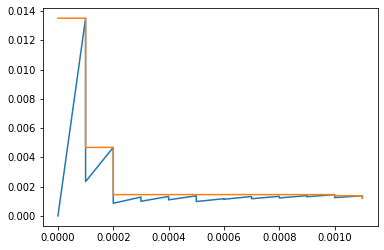

In [29]:
iou_threshold = 90 / 100

data = pd.DataFrame(all_data)
data["TP"] = (data["iou"] >= iou_threshold) * 1
data["FP"] = (data["iou"] < iou_threshold) * 1
# data = data.sort_values(by=["TP"], ascending=[False])
data["Acc TP"] = np.cumsum(data["TP"])
data["Acc FP"] = np.cumsum(data["FP"])
data["Precision"] = data["Acc TP"] / (data["Acc TP"] + data["Acc FP"])
data["Recall"] = data["Acc TP"] / 10000
plt.plot(list(data["Recall"]), list(data["Precision"]))
interpolation = list(data["Precision"])
for i in reversed(range(len(interpolation) - 1)):
    if interpolation[i+1]>interpolation[i]:
        interpolation[i]=interpolation[i+1]
# plt.figsize((15, 10))
plt.plot(list(data["Recall"]), interpolation)
from sklearn import metrics
print("Average Precision:", metrics.auc(list(data["Recall"]), interpolation))

In [26]:
data["Recall"]

73      0.0001
3638    0.0002
7987    0.0003
6863    0.0004
3002    0.0005
         ...  
2994    0.0011
2993    0.0011
2992    0.0011
2991    0.0011
8996    0.0011
Name: Recall, Length: 8997, dtype: float64

In [6]:
import time
base_dir = "/home/ec2-user/SageMaker/benchmarks/dataset/"
all_times = []
for i in tqdm(range(90000, 90100)):
    test_image_path = "X/train_{}.png".format(i)
    test_image = skimage.io.imread(base_dir + test_image_path)
    test_image = test_image.reshape(test_image.shape[0], test_image.shape[1], 1)
    start = time.time()
    r = model.detect([test_image])[0]
    all_times.append((time.time() - start))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (94051204 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (98982601 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (99980001 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (92409769 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/hom

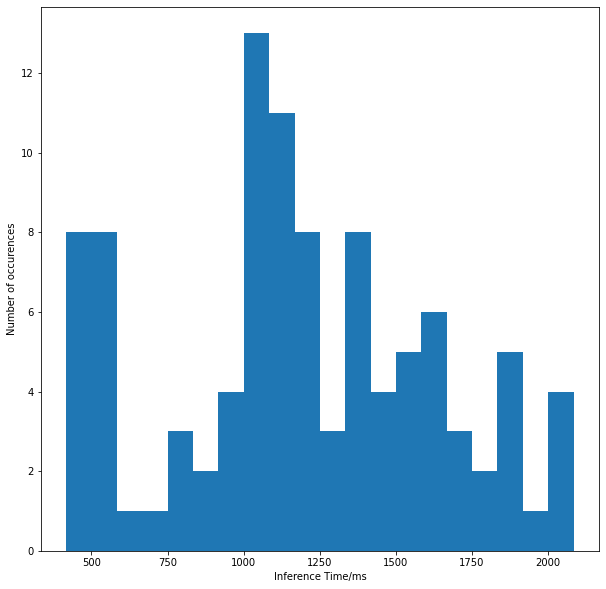

In [11]:
plt.figure(figsize=(10, 10))
plt.hist(np.array(all_times) * 1000, bins=20)
plt.xlabel("Inference Time/ms")
plt.ylabel("Number of occurences")
pass

In [12]:
all_times.sort()
length = len(all_times)
print("P50: ", all_times[int(length*0.5)]*1000, " ms")
print("P90: ", all_times[int(length*0.9)]*1000, " ms")
print("P99: ", all_times[int(length*0.99)]*1000, " ms")

P50:  1163.2590293884277  ms
P90:  1852.6365756988525  ms
P99:  2083.7409496307373  ms
